# **Data Analysis with Pyspark**

I this notebook we will focus first in the anomaly detection of dataset.


## Step 1. Pyspark Installation

If you have installed pyspark before you can skip this step.


In [1]:
# Import the os module
import os
import requests
import wget
from tqdm import tqdm

In [2]:
def download(url: str, fname: str):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    # Can also replace 'file' with a io.BytesIO object
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

In [3]:
#import zipfile module
from zipfile import ZipFile
def extract_zip(filename):
    with ZipFile(filename, 'r') as f:
        #extract in current directory
        f.extractall()

In [4]:
# importing the "tarfile" module
import tarfile
def extract_tar(filename):
    # open file
    file = tarfile.open(filename)
    # extracting file
    file.extractall()
    file.close()

## Spark 3.3.2 Installation

In [52]:
SPARK_FILE="spark-3.3.2-bin-hadoop3.tgz"
URL = "https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz"
#response = wget.download(URL, SPARK_FILE)
download(URL,SPARK_FILE)

spark-3.3.2-bin-hadoop3.tgz: 100%|█████████████████████████████████████████████████| 285M/285M [00:13<00:00, 22.9MiB/s]


In [4]:
# Path
home = os.getcwd()
# Print the current working directory
#print("Current working directory: {0}".format(home))

In [54]:
#set filename
fpath = os.path.join(home, SPARK_FILE)

In [55]:
extract_tar(fpath)

In [56]:
if os.name == 'nt':

    !del spark-3.3.2-bin-hadoop3.tgz
else:

    !rm spark-3.3.2-bin-hadoop3.tgz

## Java 11 Installation

In [57]:
if os.name == 'nt':
    url_java='https://builds.openlogic.com/downloadJDK/openlogic-openjdk/11.0.18+10/openlogic-openjdk-11.0.18+10-windows-x64.zip'
    JAVA_FILE='openjdk-11.zip'
else:
    JAVA_FILE='openjdk-11.tar.gz'
    url_java='https://builds.openlogic.com/downloadJDK/openlogic-openjdk/11.0.18+10/openlogic-openjdk-11.0.18+10-linux-x64.tar.gz'

In [58]:
download(url_java,JAVA_FILE)

openjdk-11.zip: 100%|██████████████████████████████████████████████████████████████| 214M/214M [00:07<00:00, 31.6MiB/s]


In [64]:
try:
    if os.name == 'nt':
        extract_zip(JAVA_FILE)
        !del openjdk-11.zip
    else:
        extract_tar(JAVA_FILE)
        !rm openjdk-11.tar.gz
except:
    print("")

## Enviroment setup of Spark

In [7]:
import os
# Path
home = os.getcwd()
JAVA_FOLDER='openlogic-openjdk-11.0.18+10-windows-x64'
#set filename
JAVA_HOME = os.path.join(home, JAVA_FOLDER)
SPARK_FOLDER='spark-3.3.2-bin-hadoop3'
#set filename
SPARK_HOME = os.path.join(home, SPARK_FOLDER)

In [8]:
import os
os.environ['JAVA_HOME']=JAVA_HOME
os.environ['SPARK_HOME']=SPARK_HOME

# Step 2 Importing the necessary libraries

In [9]:
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

### Creating a Spark Session

In [10]:
spark = SparkSession.builder.appName('Data Analysis').getOrCreate()
spark

## Step 3. Begin Analysis 

### Reading the dataset  using spark session

In [11]:
df = spark.read.csv('customer_data.csv',header = True)
df.show()

+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|    Customer_subtype|Number_of_houses|Avg_size_household|    Avg_age|  Customer_main_type|Avg_Salary|label|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|Lower class large...|               1|                 3|30-40 years|Family with grown...|     44905|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     37575|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     27915|    0|
|Modern, complete ...|               1|                 3|40-50 years|      Average Family|     19504|    0|
|  Large family farms|               1|                 4|30-40 years|             Farmers|     34943|    0|
|    Young and rising|               1|                 2|20-30 years|         Living well|     13064|    0|
|Large religious f.

### Get DataFrame Schema
Printing the schema, to check the datatypes

In [12]:
df.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: string (nullable = true)
 |-- Avg_size_household: string (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: string (nullable = true)
 |-- label: string (nullable = true)



First at all  found the following issues:
1. All the columns are defined as strings datatypes
2. There are categorical fields that should be indentifed
3. There are columns that have to be converted into numerical data types

### Counting the number of records

In [13]:
df.count()

2000

### Checking the number of columns

In [14]:
len(df.columns)

7

## Identifying Data types columns

In [15]:
#Get All column names and it's types
for col in df.dtypes:
    print(col[0]+" , "+col[1])

Customer_subtype , string
Number_of_houses , string
Avg_size_household , string
Avg_age , string
Customer_main_type , string
Avg_Salary , string
label , string


In [16]:
#store all column names in a list
allCols = [item[0] for item in df.dtypes]
print(allCols)

['Customer_subtype', 'Number_of_houses', 'Avg_size_household', 'Avg_age', 'Customer_main_type', 'Avg_Salary', 'label']


In [17]:
#store all column names that are categorical in a list
categoricalCols = [item[0] for item in df.dtypes if item[1].startswith('string')]
print(categoricalCols)

['Customer_subtype', 'Number_of_houses', 'Avg_size_household', 'Avg_age', 'Customer_main_type', 'Avg_Salary', 'label']


In [18]:
#store all column names that are continous in a list
continuousCols =[item[0] for item in df.dtypes if item[1].startswith('bigint')]
print(continuousCols)

[]


### Segregating the desired columns to convert the data type into IntegerType

In [19]:
numeric_index = [1,2,5,6]
numeric_cols = [allCols[val] for val in numeric_index]

In [20]:
numeric_cols

['Number_of_houses', 'Avg_size_household', 'Avg_Salary', 'label']

In [21]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType


The first option you have when it comes to converting data types is pyspark.sql.Column.cast() function that converts the input column to the specified data type.

In [22]:
for column in numeric_cols:
    df = df.withColumn(column,f.col(column).cast(IntegerType()))

### Checking the schema after converting the numerical columns into IntegerType

In [23]:
df.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)



## Complementary information

Alternatively, you can use pyspark.sql.DataFrame.selectExpr function by specifying the corresponding SQL expressions that can cast the data type of desired columns, as shown below.

In [24]:
dfa = df.selectExpr(
    'cast(Number_of_houses as int) Number_of_houses',
)

In [25]:
dfa.printSchema()

root
 |-- Number_of_houses: integer (nullable = true)



Sometimes we need add date type
```
'to_date(colA, \'dd-MM-yyyy\') colA',
```

In [26]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType
dfa = df \
    .withColumn('Number_of_houses', col('Number_of_houses').cast(IntegerType()))

and the datatype equivalent, first we define dhe universal defined function 

```
# UDF to process the date column
func = udf(lambda x: datetime.strptime(x, '%d-%m-%Y'), DateType())

with 

.withColumn('colA', func(col('colA'))) \
```

In [27]:
dfa.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)



In [28]:
from pyspark.sql import SparkSession
# Create an instance of spark session
spark_session = SparkSession.builder \
    .master('local[1]') \
    .appName('Example') \
    .getOrCreate()

In [29]:
# Removing Global views
spark.catalog.dropGlobalTempView("dfa")

False

In [30]:
# First we need to register the DF as a global temporary view
df.createGlobalTempView("dfa")
dfa = spark_session.sql(
    """
    SELECT 
        cast(Number_of_houses as int) Number_of_houses
    FROM global_temp.dfa
    """
)

In [31]:
dfa.printSchema()

root
 |-- Number_of_houses: integer (nullable = true)



### Creating a variable to store all the numerical columns into a list

In [32]:
numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']
numeric_columns

['Number_of_houses', 'Avg_size_household', 'Avg_Salary', 'label']

In [33]:
df.show()

+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|    Customer_subtype|Number_of_houses|Avg_size_household|    Avg_age|  Customer_main_type|Avg_Salary|label|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|Lower class large...|               1|                 3|30-40 years|Family with grown...|     44905|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     37575|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     27915|    0|
|Modern, complete ...|               1|                 3|40-50 years|      Average Family|     19504|    0|
|  Large family farms|               1|                 4|30-40 years|             Farmers|     34943|    0|
|    Young and rising|               1|                 2|20-30 years|         Living well|     13064|    0|
|Large religious f.

# Case 1 - Working with only integers

In [125]:
dfa=df.select(*numeric_columns)

In [126]:
#dfa=df.select(col('Avg_Salary'))

In [127]:
dfa.printSchema()

root
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)



### Creating a customized function 

In [128]:
def find_outliers(df,numerical_columns=None):
    if numerical_columns==None:
        # Identifying the numerical columns in a spark dataframe
        numeric_columns = [column[0] for column in df.dtypes if column[1]=='int'or column[1]=='double']
    else:
        #Custom numerical columns
        numeric_columns =numerical_columns

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

### Using the customized Outlier function and applying it to a spark dataframe

In [129]:
new_df = find_outliers(dfa)
new_df.show()

+----------------+------------------+----------+-----+--------------+
|Number_of_houses|Avg_size_household|Avg_Salary|label|total_outliers|
+----------------+------------------+----------+-----+--------------+
|               1|                 3|     44905|    0|             0|
|               1|                 2|     37575|    0|             0|
|               1|                 2|     27915|    0|             0|
|               1|                 3|     19504|    0|             0|
|               1|                 4|     34943|    0|             0|
|               1|                 2|     13064|    0|             0|
|               2|                 3|     29090|    0|             1|
|               1|                 2|      6895|    0|             0|
|               1|                 2|     35497|    0|             0|
|               2|                 3|     30800|    0|             1|
|               1|                 4|     39157|    0|             0|
|               1|  

### Fitering the above dataframe, to select only those records where the outlier count is < = 1

In [39]:
new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*dfa.columns)

new_df_with_no_outliers.show()

+----------------+------------------+----------+-----+
|Number_of_houses|Avg_size_household|Avg_Salary|label|
+----------------+------------------+----------+-----+
|               1|                 3|     44905|    0|
|               1|                 2|     37575|    0|
|               1|                 2|     27915|    0|
|               1|                 3|     19504|    0|
|               1|                 4|     34943|    0|
|               1|                 2|     13064|    0|
|               2|                 3|     29090|    0|
|               1|                 2|      6895|    0|
|               1|                 2|     35497|    0|
|               2|                 3|     30800|    0|
|               1|                 4|     39157|    0|
|               1|                 3|     40839|    0|
|               1|                 2|     30008|    0|
|               1|                 3|     37209|    0|
|               1|                 1|     45361|    0|
|         

### The count of the dataframe, after removing the outliers

In [40]:
new_df_with_no_outliers.count()

1938

### The dataset, which contains 2 or more outliers in each record

In [41]:
data_with_outliers = new_df.filter(new_df['total_Outliers']>=2)
data_with_outliers.show()

+----------------+------------------+----------+-----+--------------+
|Number_of_houses|Avg_size_household|Avg_Salary|label|total_outliers|
+----------------+------------------+----------+-----+--------------+
|               2|                 5|     40832|    0|             2|
|               1|                 3|    762769|    1|             2|
|               2|                 3|   6138618|    0|             2|
|               1|                 2|  12545905|    1|             2|
|               2|                 3|     30117|    1|             2|
|               2|                 2|    690080|    0|             2|
|               2|                 5|     37394|    0|             2|
|               1|                 4|  35032441|    1|             2|
|               1|                 4|    682348|    1|             2|
|               2|                 3|    762483|    0|             2|
|               2|                 4|     20503|    1|             2|
|               2|  

In [42]:
# Selecting the numerical columns from the original dataframe and converting into pandas

numeric_columns

['Number_of_houses', 'Avg_size_household', 'Avg_Salary', 'label']

### Converting a spark dataframe into pandas dataframe, which enables us to plot the graphs using seaborn and matplotlib

In [43]:
original_numerical_df = dfa.select(*numeric_columns).toPandas()

original_numerical_df.head(10)

,Number_of_houses,Avg_size_household,Avg_Salary,label
0,1,3,44905,0
1,1,2,37575,0
2,1,2,27915,0
3,1,3,19504,0
4,1,4,34943,0
5,1,2,13064,0
6,2,3,29090,0
7,1,2,6895,0
8,1,2,35497,0
9,2,3,30800,0


In [44]:
# Plotting the box for the dataset after removing the outliers

dataset_after_removing_outliers = new_df_with_no_outliers.toPandas()
dataset_after_removing_outliers.head(10)

,Number_of_houses,Avg_size_household,Avg_Salary,label
0,1,3,44905,0
1,1,2,37575,0
2,1,2,27915,0
3,1,3,19504,0
4,1,4,34943,0
5,1,2,13064,0
6,2,3,29090,0
7,1,2,6895,0
8,1,2,35497,0
9,2,3,30800,0


In [45]:
numeric_columns

['Number_of_houses', 'Avg_size_household', 'Avg_Salary', 'label']

### Plotting the box plot, to check the outliers in the original dataframe., and comaring it with the new dataframe after removing outliers

In [173]:
original_numerical_df

,Number_of_houses,Avg_size_household,Avg_Salary,label
0,1,3,44905,0
1,1,2,37575,0
2,1,2,27915,0
3,1,3,19504,0
4,1,4,34943,0
...,...,...,...,...
1995,1,2,45857,0
1996,1,4,45665,0
1997,1,2,32903,0
1998,1,3,46911924,0


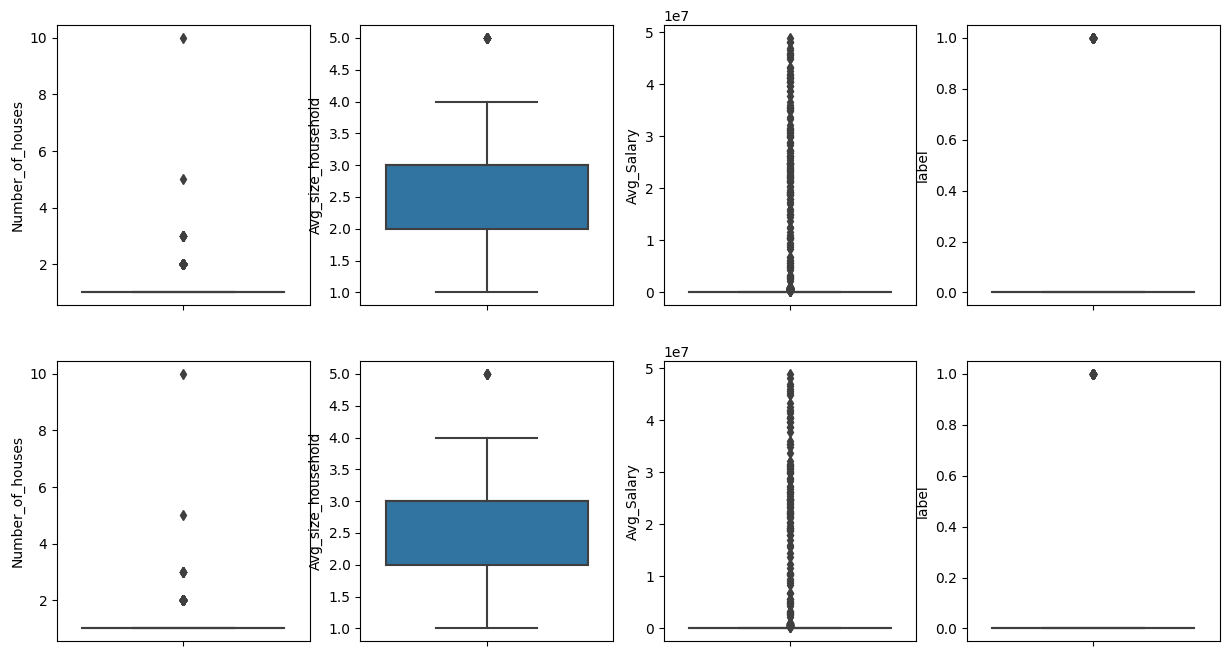

In [185]:
size_columns=len(original_numerical_df.columns)
fig,ax = plt.subplots(2,size_columns,figsize=(15,8))
for i,dfa in enumerate([original_numerical_df,dataset_after_removing_outliers]):
  
    for j, col in enumerate(numeric_columns):
        sns.boxplot(data = dfa, y=col,ax=ax[i][j])

# Case 2 - Working with strings

In [47]:
df.show(5)

+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|    Customer_subtype|Number_of_houses|Avg_size_household|    Avg_age|  Customer_main_type|Avg_Salary|label|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
|Lower class large...|               1|                 3|30-40 years|Family with grown...|     44905|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     37575|    0|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     27915|    0|
|Modern, complete ...|               1|                 3|40-50 years|      Average Family|     19504|    0|
|  Large family farms|               1|                 4|30-40 years|             Farmers|     34943|    0|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+
only showing top 5 

In [48]:
df.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)



 ## Encoding string values into numeric values in Spark DataFrame
 Let us assume that we are interested to encoding the columns that are strings.

StringIndexer encodes a string column of labels to a column of label indices. StringIndexer can encode multiple columns. 

## Single Column Encoding

In [49]:
from pyspark.ml.feature import StringIndexer
label_col ='Customer_subtype'
indexer = StringIndexer(inputCol=label_col, outputCol="idx_{0}".format(label_col))
indexed = indexer.fit(df).transform(df)
indexed.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- idx_Customer_subtype: double (nullable = false)



## Multiple Columns Encodings
We assume that we want to encode all string columns

In [147]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import VectorAssembler

In [148]:
#Get data type of a specific column from dtypes
#store all column names that are categorical in a list
categoricalCols = [item[0] for item in df.dtypes if item[1].startswith('string')]
print(categoricalCols)

['Customer_subtype', 'Avg_age', 'Customer_main_type']


In [149]:
label_col =categoricalCols  # List of string columns to encode

In [150]:
label_col

['Customer_subtype', 'Avg_age', 'Customer_main_type']

For classifications problems,
if you want to use ML you should index label as well
if you want to use MLlib it is not necessary
For regression problems you should omit label in the indexing
as shown below

In [151]:
# Indexers encode strings with doubles
string_indexers = [
   StringIndexer(inputCol=x, outputCol="idx_{0}".format(x))

   for x in df.columns if x in label_col # Exclude other columns if needed
]

In [152]:
df.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)



In [153]:
inputCols=["idx_{0}".format(x) for x in label_col]

In [154]:
#inputCols=["idx_{0}".format(x) for x in df.columns if x == label_col]

In [155]:
inputCols

['idx_Customer_subtype', 'idx_Avg_age', 'idx_Customer_main_type']

In [156]:
# Assembles multiple columns into a single vector
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features"
)

In [157]:
pipeline = Pipeline(stages=string_indexers + [assembler])
#pipeline = Pipeline(stages=string_indexers )
model = pipeline.fit(df)
new_df = model.transform(df)

In [158]:
new_df.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- idx_Customer_subtype: double (nullable = false)
 |-- idx_Avg_age: double (nullable = false)
 |-- idx_Customer_main_type: double (nullable = false)
 |-- features: vector (nullable = true)



In [159]:
new_df.show(3)

+--------------------+----------------+------------------+-----------+--------------------+----------+-----+--------------------+-----------+----------------------+--------------+
|    Customer_subtype|Number_of_houses|Avg_size_household|    Avg_age|  Customer_main_type|Avg_Salary|label|idx_Customer_subtype|idx_Avg_age|idx_Customer_main_type|      features|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+--------------------+-----------+----------------------+--------------+
|Lower class large...|               1|                 3|30-40 years|Family with grown...|     44905|    0|                 0.0|        1.0|                   0.0| [0.0,1.0,0.0]|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     37575|    0|                18.0|        1.0|                   0.0|[18.0,1.0,0.0]|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     2791

In [160]:
#new_df.show(5)

In [161]:
pandasDF = new_df.toPandas()
pandasDF.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]"
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]"


In [162]:
#dfb=new_df.select(*inputCols)

In [165]:
dfb=new_df

In [166]:
dfb.show(5)

+--------------------+----------------+------------------+-----------+--------------------+----------+-----+--------------------+-----------+----------------------+--------------+
|    Customer_subtype|Number_of_houses|Avg_size_household|    Avg_age|  Customer_main_type|Avg_Salary|label|idx_Customer_subtype|idx_Avg_age|idx_Customer_main_type|      features|
+--------------------+----------------+------------------+-----------+--------------------+----------+-----+--------------------+-----------+----------------------+--------------+
|Lower class large...|               1|                 3|30-40 years|Family with grown...|     44905|    0|                 0.0|        1.0|                   0.0| [0.0,1.0,0.0]|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     37575|    0|                18.0|        1.0|                   0.0|[18.0,1.0,0.0]|
|Mixed small town ...|               1|                 2|30-40 years|Family with grown...|     2791

In [169]:
new_df_b = find_outliers(dfb,inputCols)
new_df_b.printSchema()

root
 |-- Customer_subtype: string (nullable = true)
 |-- Number_of_houses: integer (nullable = true)
 |-- Avg_size_household: integer (nullable = true)
 |-- Avg_age: string (nullable = true)
 |-- Customer_main_type: string (nullable = true)
 |-- Avg_Salary: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- idx_Customer_subtype: double (nullable = false)
 |-- idx_Avg_age: double (nullable = false)
 |-- idx_Customer_main_type: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- total_outliers: integer (nullable = false)



In [192]:
pandasDFb = new_df_b.toPandas()
pandasDFb.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features,total_outliers
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]",0
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]",0
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]",0
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]",0
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]",0


In [171]:
pandasDFb[pandasDFb["total_outliers"] > 0]

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features,total_outliers
5,Young and rising,1,2,20-30 years,Living well,13064,0,6.0,4.0,5.0,"[6.0, 4.0, 5.0]",1
63,Young and rising,2,1,20-30 years,Living well,28875,0,6.0,4.0,5.0,"[6.0, 4.0, 5.0]",1
69,Porchless seniors: no front yard,1,2,60-70 years,Retired and Religious,31553,0,24.0,3.0,3.0,"[24.0, 3.0, 3.0]",1
71,Young seniors in the city,1,2,60-70 years,Cruising Seniors,10511,0,26.0,3.0,8.0,"[26.0, 3.0, 8.0]",1
84,Young and rising,1,2,20-30 years,Living well,37780,0,6.0,4.0,5.0,"[6.0, 4.0, 5.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...
1888,Young and rising,1,2,20-30 years,Living well,13647,0,6.0,4.0,5.0,"[6.0, 4.0, 5.0]",1
1899,Own home elderly,1,1,60-70 years,Cruising Seniors,22087,0,30.0,3.0,8.0,"[30.0, 3.0, 8.0]",1
1925,Own home elderly,1,2,60-70 years,Cruising Seniors,21040,0,30.0,3.0,8.0,"[30.0, 3.0, 8.0]",1
1953,Mixed seniors,1,1,70-80 years,Successful hedonists,15518,0,9.0,5.0,4.0,"[9.0, 5.0, 4.0]",1


In [195]:
pandasDFb.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features,total_outliers
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]",0
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]",0
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]",0
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]",0
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]",0


(0, 'idx_Customer_subtype')
(1, 'idx_Avg_age')
(2, 'idx_Customer_main_type')


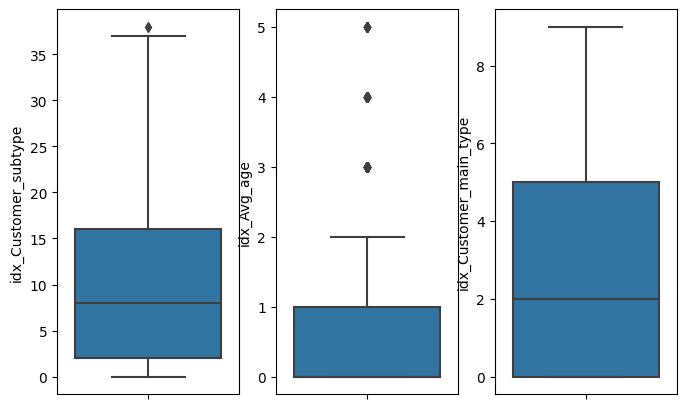

In [226]:
data=pandasDFb
size_columns=len(inputCols)
fig,ax = plt.subplots(1,size_columns,figsize=(8,5))
for i in enumerate(inputCols):
    print(i)
    sns.boxplot(data=data, y=i[1],ax=ax[i[0]])

In [230]:
inputCols

['idx_Customer_subtype', 'idx_Avg_age', 'idx_Customer_main_type']

In [246]:
def calculate_bounds(df):
    bounds = {
        c: dict(
            zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))
        )
        for c,d in zip(df.columns, df.dtypes) if d[1] == "int" or d[1]=='double'
    }

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['min'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['max'] = bounds[c]['q3'] + (iqr * 1.5)

    return bounds

In [247]:
calculate_bounds(df)

{'Number_of_houses': {'q1': 1.0, 'q3': 1.0, 'min': 1.0, 'max': 1.0},
 'Avg_size_household': {'q1': 2.0, 'q3': 3.0, 'min': 0.5, 'max': 4.5},
 'Avg_Salary': {'q1': 20315.0, 'q3': 42949.0, 'min': -13636.0, 'max': 76900.0},
 'label': {'q1': 0.0, 'q3': 0.0, 'min': 0.0, 'max': 0.0}}

In [255]:
dfc=dfb.select(inputCols)

In [256]:
calculate_bounds(dfc)

{'idx_Customer_subtype': {'q1': 2.0, 'q3': 16.0, 'min': -19.0, 'max': 37.0},
 'idx_Avg_age': {'q1': 0.0, 'q3': 1.0, 'min': -1.5, 'max': 2.5},
 'idx_Customer_main_type': {'q1': 0.0, 'q3': 5.0, 'min': -7.5, 'max': 12.5}}

In [290]:
def single_flag_outliers(df, singleCol):
    c=singleCol
    dfc=df.select(c)
    bounds = calculate_bounds(dfc)
    outliers = {}
    
    return df.select(*df.columns,
        *[f.when(~f.col(c).between(bounds[c]['min'], bounds[c]['max']),"yes").otherwise("no").alias(c+'_outlier')]
    )

In [291]:
inputCols[0]

'idx_Customer_subtype'

In [292]:
res=single_flag_outliers(dfc,inputCols[0])
res.show(5)

+--------------------+-----------+----------------------+----------------------------+
|idx_Customer_subtype|idx_Avg_age|idx_Customer_main_type|idx_Customer_subtype_outlier|
+--------------------+-----------+----------------------+----------------------------+
|                 0.0|        1.0|                   0.0|                          no|
|                18.0|        1.0|                   0.0|                          no|
|                18.0|        1.0|                   0.0|                          no|
|                 4.0|        0.0|                   1.0|                          no|
|                25.0|        1.0|                   7.0|                          no|
+--------------------+-----------+----------------------+----------------------------+
only showing top 5 rows



In [299]:
def multiple_flag_outliers(df, columns):
    dfc=df.select(*columns)
    bounds = calculate_bounds(dfc)
    outliers = {}
    
    return df.select(*df.columns,*[
        f.when(~f.col(c).between(bounds[c]['min'], bounds[c]['max']),"yes").otherwise("no").alias(c+'_outlier') for c in columns
    ]
    )

In [300]:
res=multiple_flag_outliers(dfc,inputCols)
res.show(5)

+--------------------+-----------+----------------------+----------------------------+-------------------+------------------------------+
|idx_Customer_subtype|idx_Avg_age|idx_Customer_main_type|idx_Customer_subtype_outlier|idx_Avg_age_outlier|idx_Customer_main_type_outlier|
+--------------------+-----------+----------------------+----------------------------+-------------------+------------------------------+
|                 0.0|        1.0|                   0.0|                          no|                 no|                            no|
|                18.0|        1.0|                   0.0|                          no|                 no|                            no|
|                18.0|        1.0|                   0.0|                          no|                 no|                            no|
|                 4.0|        0.0|                   1.0|                          no|                 no|                            no|
|                25.0|        1.0|

In [309]:
# specify column names
columns = inputCols
  
# creating a dataframe from the lists of data
dataframe = res
  
# select ID where ID less than 3
dataframe.select(*res.columns,'idx_Avg_age_outlier').where(dataframe.idx_Avg_age_outlier == 'yes').show()

+--------------------+-----------+----------------------+----------------------------+-------------------+------------------------------+-------------------+
|idx_Customer_subtype|idx_Avg_age|idx_Customer_main_type|idx_Customer_subtype_outlier|idx_Avg_age_outlier|idx_Customer_main_type_outlier|idx_Avg_age_outlier|
+--------------------+-----------+----------------------+----------------------------+-------------------+------------------------------+-------------------+
|                 6.0|        4.0|                   5.0|                          no|                yes|                            no|                yes|
|                 6.0|        4.0|                   5.0|                          no|                yes|                            no|                yes|
|                24.0|        3.0|                   3.0|                          no|                yes|                            no|                yes|
|                26.0|        3.0|                  

In [301]:
pandasDFc = res.toPandas()
pandasDFc.head()

,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,idx_Customer_subtype_outlier,idx_Avg_age_outlier,idx_Customer_main_type_outlier
0,0.0,1.0,0.0,no,no,no
1,18.0,1.0,0.0,no,no,no
2,18.0,1.0,0.0,no,no,no
3,4.0,0.0,1.0,no,no,no
4,25.0,1.0,7.0,no,no,no


In [304]:
dfd=pandasDFc

In [307]:
dfd[(dfd.idx_Customer_subtype_outlier == 'yes') | (dfd.idx_Avg_age_outlier == 'yes') | (dfd.idx_Customer_main_type_outlier == 'yes')]


,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,idx_Customer_subtype_outlier,idx_Avg_age_outlier,idx_Customer_main_type_outlier
5,6.0,4.0,5.0,no,yes,no
63,6.0,4.0,5.0,no,yes,no
69,24.0,3.0,3.0,no,yes,no
71,26.0,3.0,8.0,no,yes,no
84,6.0,4.0,5.0,no,yes,no
...,...,...,...,...,...,...
1888,6.0,4.0,5.0,no,yes,no
1899,30.0,3.0,8.0,no,yes,no
1925,30.0,3.0,8.0,no,yes,no
1953,9.0,5.0,4.0,no,yes,no


# Cleaning Dataset Optional

In [91]:
### USER DEFINED FUNCTION: OUTLIER TREATMENT USING CAPPING & FLOORING ###

from pyspark.sql.functions import when
from time import *

def outlier_capping_flooring(df,var_list,flooring_pct,capping_pct):
    
    outlier_start_time = time()  
 
  # Creating A Copy of Source Data Frame
    raw_data_treated = df
  
  # Performing Outlier Treatment
    for var in var_list:
        lower_bound = raw_data_treated.approxQuantile(var,[flooring_pct],0)[0]
        upper_bound = raw_data_treated.approxQuantile(var,[capping_pct],0)[0]
        raw_data_treated = raw_data_treated.withColumn(var,
                                                       when(raw_data_treated[var] < lower_bound, lower_bound)
                                                       .otherwise(raw_data_treated[var]))
        raw_data_treated = raw_data_treated.withColumn(var,
                                                       when(raw_data_treated[var] > upper_bound, upper_bound)
                                                       .otherwise(raw_data_treated[var]))
    outlier_end_time = time()
    outlier_elapsed_time = (outlier_end_time - outlier_start_time)/60
    print("\nTime To Perform Outlier Treatment Using Capping & Flooring: %.3f Minutes\n" % outlier_elapsed_time)  
    
    return(raw_data_treated)

In [92]:
### USER DEFINED FUNCTION: OUTLIER TREATMENT USING IQR METHOD ###

from pyspark.sql.functions import when
from time import *

def outlier_iqr(df,var_list, multiplier):
    
    outlier_start_time = time()  
 
  # Creating A Copy of Source Data Frame
    raw_data_treated = df
  
  # Performing Outlier Treatment
    for var in var_list:
        quartile_1 = raw_data_treated.approxQuantile(var,[0.25],0)[0]
        quartile_3 = raw_data_treated.approxQuantile(var,[0.75],0)[0]
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * multiplier)
        upper_bound = quartile_3 + (iqr * multiplier)
        raw_data_treated = raw_data_treated.withColumn(var,
                                                       when(raw_data_treated[var] < lower_bound, lower_bound)
                                                       .otherwise(raw_data_treated[var]))
        raw_data_treated = raw_data_treated.withColumn(var,
                                                       when(raw_data_treated[var] > upper_bound, upper_bound)
                                                       .otherwise(raw_data_treated[var]))
    outlier_end_time = time()
    outlier_elapsed_time = (outlier_end_time - outlier_start_time)/60
    print("\nTime To Perform Outlier Treatment Using IQR Method: %.3f Minutes\n" % outlier_elapsed_time)  
    
    return(raw_data_treated)


# In[ ]:

In [93]:
### USER DEFINED FUNCTION: MISSING VALUE TREATMENT USING MEAN IMPUTATION ###

from pyspark.sql.functions import mean

def missing_value_mean(df, var_list):
    
    missing_value_start_time = time()  
  
  # Performing Outlier Treatment
    mean_dict = df[var_list].select(*[mean(c).alias(c) for c in df[var_list].columns]).toPandas().to_dict('r')[0]
    raw_data_treated = df.fillna(mean_dict)
    
    missing_value_end_time = time()
    missing_value_elapsed_time = (missing_value_end_time - missing_value_start_time)/60
    print("\nTime To Perform Missing Value Treatment Using Mean Imputation: %.3f Minutes\n" % missing_value_elapsed_time)  
    
    return(raw_data_treated)    


In [94]:
### USER DEFINED FUNCTION: MISSING VALUE TREATMENT USING MEDIAN IMPUTATION ###

import pandas as pd

def missing_value_median(df, var_list):
    
    missing_value_start_time = time()  
  
  # Performing Outlier Treatment
    temp_df = pd.DataFrame()
    final_df = pd.DataFrame()
    
    for col_name in var_list:
        temp_df.loc[0,"Column_Name"] = col_name
        temp_df.loc[0,"Column_Median"] = df.approxQuantile(col_name,[0.5],0)
        final_df = final_df.append(temp_df)
    final_df = final_df.transpose()
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]
    final_df.index.name = None
    final_df.reset_index(drop=True, inplace=True)
    median_dict = final_df.to_dict('r')[0]
    
    raw_data_treated = df.fillna(median_dict)
        
    missing_value_end_time = time()
    missing_value_elapsed_time = (missing_value_end_time - missing_value_start_time)/60
    print("\nTime To Perform Missing Value Treatment Using Median Imputation: %.3f Minutes\n" % missing_value_elapsed_time)  
    
    return(raw_data_treated)

In [95]:
#### USER INPUT SECTION ###

# Global Variables #
raw_data =new_df
global_treatment_var_list=inputCols
global_outlier_capping_pct = 0.99
global_outlier_flooring_pct = 0.01
global_outlier_iqr_multiplier = 1.5

In [96]:
# Outlier Treatment Using Capping & Flooring #
treated_data_1 = outlier_capping_flooring(raw_data,
                                        global_treatment_var_list,
                                        global_outlier_flooring_pct,
                                        global_outlier_capping_pct)


Time To Perform Outlier Treatment Using Capping & Flooring: 0.011 Minutes



In [97]:

pd_treated_data_1 = treated_data_1.toPandas()
pd_treated_data_1.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]"
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]"


In [98]:
# Outlier Treatment Using IQR Method #
treated_data_2 = outlier_iqr(raw_data,
                             global_treatment_var_list,
                             global_outlier_iqr_multiplier)


Time To Perform Outlier Treatment Using IQR Method: 0.010 Minutes



In [99]:
pd_treated_data_2 = treated_data_2.toPandas()
pd_treated_data_2.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]"
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]"


In [100]:
# Missing Value Treatment Using Mean Imputation #
treated_data_3 = missing_value_mean(treated_data_1,
                                    global_treatment_var_list)


Time To Perform Missing Value Treatment Using Mean Imputation: 0.005 Minutes



C:\Users\rusla\AppData\Local\Temp\ipykernel_60572\588799151.py:10: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  mean_dict = df[var_list].select(*[mean(c).alias(c) for c in df[var_list].columns]).toPandas().to_dict('r')[0]


In [101]:
pd_treated_data_3 = treated_data_3.toPandas()
pd_treated_data_3.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]"
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]"


In [102]:
# Missing Value Treatment Using Median Imputation #
treated_data_4 = missing_value_median(treated_data_2,
                                      global_treatment_var_list)

C:\Users\rusla\AppData\Local\Temp\ipykernel_60572\1441828963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(temp_df)
C:\Users\rusla\AppData\Local\Temp\ipykernel_60572\1441828963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(temp_df)



Time To Perform Missing Value Treatment Using Median Imputation: 0.007 Minutes



C:\Users\rusla\AppData\Local\Temp\ipykernel_60572\1441828963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(temp_df)
C:\Users\rusla\AppData\Local\Temp\ipykernel_60572\1441828963.py:22: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  median_dict = final_df.to_dict('r')[0]


In [103]:
pd_treated_data_4 = treated_data_4.toPandas()
pd_treated_data_4.head()

,Customer_subtype,Number_of_houses,Avg_size_household,Avg_age,Customer_main_type,Avg_Salary,label,idx_Customer_subtype,idx_Avg_age,idx_Customer_main_type,features
0,Lower class large families,1,3,30-40 years,Family with grown ups,44905,0,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
1,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,37575,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
2,Mixed small town dwellers,1,2,30-40 years,Family with grown ups,27915,0,18.0,1.0,0.0,"[18.0, 1.0, 0.0]"
3,"Modern, complete families",1,3,40-50 years,Average Family,19504,0,4.0,0.0,1.0,"[4.0, 0.0, 1.0]"
4,Large family farms,1,4,30-40 years,Farmers,34943,0,25.0,1.0,7.0,"[25.0, 1.0, 7.0]"
